## Deep Compressive Object Decoder (DCOD)
Implementation and proof of work.

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from network import deep_decoder
import tensorflow as tf
from tensorflow.keras import layers as ls, activations as acts
import tensorflow_addons as tfa
from skimage.restoration import unwrap_phase
from fringe.utils.io import import_image, export_image
from fringe.utils.modifiers import ImageToArray, PreprocessHologram, ConvertToTensor
from fringe.process.gpu import AngularSpectrumSolver as AsSolver

device = 'gpu'

if device == "gpu":
  if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print('GPU is up and running')
    device = "/gpu:0"
  else:
    print('No GPUs found. The process will run on CPU.')
    device = "/cpu:0"
elif device == "tpu":
  if len(tf.config.experimental.list_physical_devices('TPU')) > 0:
    print('TPU is up and running')
    device = "/tpu:0"
  else:
    print('No TPUs found. The process will run on CPU.')
    device = "/cpu:0"
else:
  device = "/cpu:0"

dtype_f = tf.float32
dtype_c = tf.complex64

GPU is not available. The program will run on CPU


### Samples

#### Sample 1: Cheek Cells

Image imported from: Dataset/Cheek cells/background.tif
Image imported from: Dataset/Cheek cells/hologram.tif


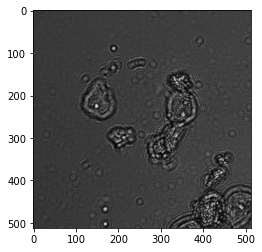

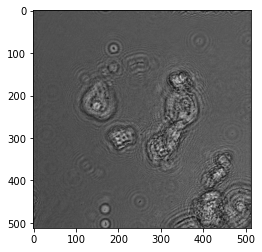

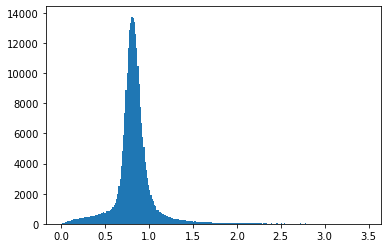

In [4]:
hologram_path = 'Dataset/Cheek cells/hologram.tif'
background_path = 'Dataset/Cheek cells/background.tif'

p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')
bg = import_image(background_path, preprocessor=p1)
p2 = PreprocessHologram(background=bg)
p3 = ConvertToTensor(dtype=dtype_c)
hologram = import_image(hologram_path, preprocessor=[p1, p2, p3])
hologram_amp = tf.math.abs(hologram)

solver = AsSolver(shape=hologram_amp.shape, dx=1.12, dy=1.12, wavelength=532e-3)
z = 238
rec = solver.solve(hologram, z)
amp = np.abs(rec)
#phase = unwrap_phase(np.angle(rec))

plt.imshow(hologram_amp.numpy(), cmap='gray')
plt.show()
plt.imshow(amp, cmap='gray')
plt.show()
plt.hist((hologram_amp.numpy()).flatten(), 256)
plt.show()

#### Sample 2: Red Blood Cells

Image imported from: Dataset/RBCs/background.tif
Image imported from: Dataset/RBCs/hologram.tif


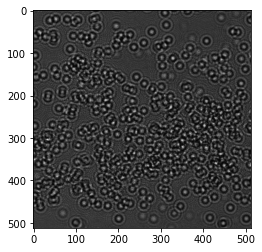

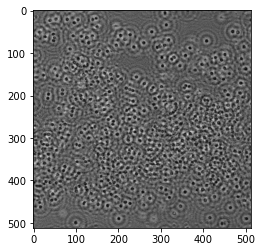

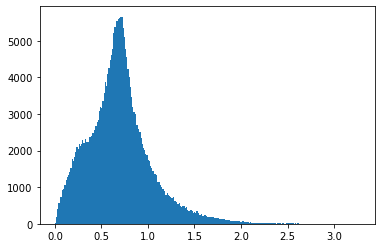

In [6]:
hologram_path = 'Dataset/RBCs/hologram.tif'
background_path = 'Dataset/RBCs/background.tif'

p1 = ImageToArray(bit_depth=16, channel='gray', dtype='float32')
bg = import_image(background_path, preprocessor=p1)
p2 = PreprocessHologram(background=bg)
p3 = ConvertToTensor(dtype=dtype_c)
hologram = import_image(hologram_path, preprocessor=[p1, p2, p3])
hologram_amp = tf.math.abs(hologram)

solver = AsSolver(shape=hologram_amp.shape, dx=1.12, dy=1.12, wavelength=532e-3)
z = 315
rec = solver.solve(hologram, z)
amp = np.abs(rec)
#phase = unwrap_phase(np.angle(rec))

plt.imshow(hologram_amp.numpy(), cmap='gray')
plt.show()
plt.imshow(amp, cmap='gray')
plt.show()
plt.hist((hologram_amp.numpy()).flatten(), 256)
plt.show()

#### Sample 3: Diffraction Grating

Image imported from: Dataset/Grating/background.tif
Image imported from: Dataset/Grating/hologram.tif


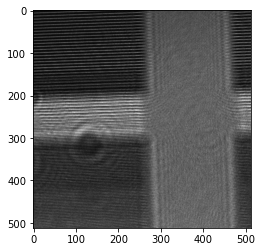

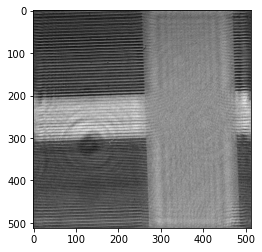

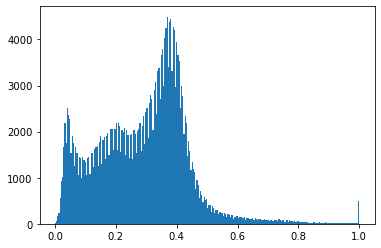

In [13]:
hologram_path = 'Dataset/Grating/hologram.tif'
background_path = 'Dataset/Grating/background.tif'

p1 = ImageToArray(bit_depth=16, channel='gray', dtype='float32')
bg = import_image(background_path, preprocessor=p1)
p2 = PreprocessHologram(background=bg)
p3 = ConvertToTensor(dtype=dtype_c)
hologram = import_image(hologram_path, preprocessor=[p1, p2, p3])
hologram_amp = tf.math.abs(hologram)

solver = AsSolver(shape=hologram_amp.shape, dx=1.12, dy=1.12, wavelength=532e-3)
z = 956
rec = solver.solve(hologram, z)
amp = np.abs(rec)
#phase = unwrap_phase(np.angle(rec))

plt.imshow(hologram_amp.numpy(), cmap='gray')
plt.show()
plt.imshow(amp, cmap='gray')
plt.show()
plt.hist((hologram_amp.numpy()).flatten(), 256)
plt.show()

#### Sample 4: USAF 1951

Image imported from: Dataset/USAF 1951/background.tif
Image imported from: Dataset/USAF 1951/hologram.tif


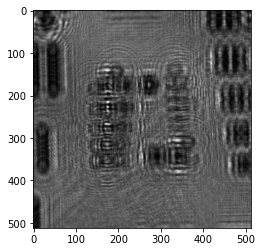

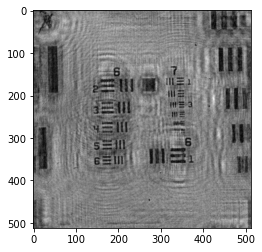

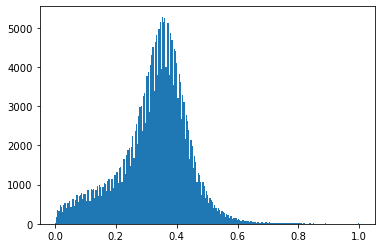

In [14]:
hologram_path = 'Dataset/USAF 1951/hologram.tif'
background_path = 'Dataset/USAF 1951/background.tif'

p1 = ImageToArray(bit_depth=16, channel='gray', dtype='float32')
bg = import_image(background_path, preprocessor=p1)
p2 = PreprocessHologram(background=bg)
p3 = ConvertToTensor(dtype=dtype_c)
hologram = import_image(hologram_path, preprocessor=[p1, p2, p3])
hologram_amp = tf.math.abs(hologram)

solver = AsSolver(shape=hologram_amp.shape, dx=1.12, dy=1.12, wavelength=532e-3)
z = 1065
rec = solver.solve(hologram, z)
amp = np.abs(rec)
#phase = unwrap_phase(np.angle(rec))

plt.imshow(hologram_amp.numpy(), cmap='gray')
plt.show()
plt.imshow(amp, cmap='gray')
plt.show()
plt.hist((hologram_amp.numpy()).flatten(), 256)
plt.show()

#### Sample 5: Simulation

Image imported from: Dataset/Simulation source images/baboon.png
Image imported from: Dataset/Simulation source images/peppers.png


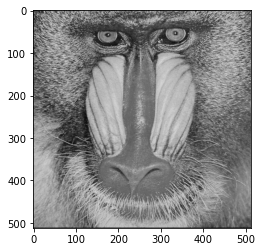

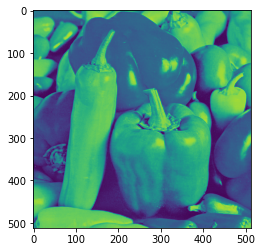

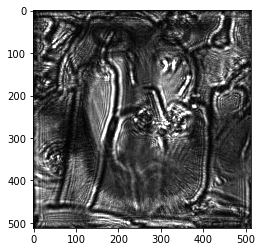

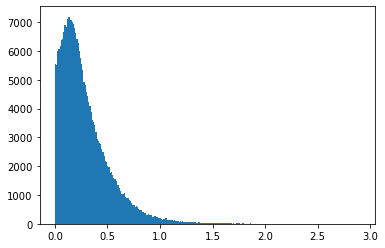

In [15]:
from skimage.filters import gaussian
from misc_functions import Scale


amp_path = 'Dataset/Simulation source images/baboon.png'
ph_path = 'Dataset/Simulation source images/peppers.png'

p1 = ImageToArray(bit_depth=8, channel='gray', crop_window=None, dtype='float32')
amplitude = import_image(amp_path, preprocessor=p1)
phase = import_image(ph_path, preprocessor=p1)

# Adjusting contrast
amplitude = Scale(amplitude, perc=1, max_val=1)

# Blurriness
sigma = 0 #np.exp(3)
amplitude = gaussian(amplitude, sigma, mode='reflect', truncate=np.round(10 * sigma) + 1)

phase /= np.max(phase)
phase *= 2 * np.pi - 0.2 * np.pi
phase -= np.pi

solver = AsSolver(shape=amplitude.shape, dx=1.12, dy=1.12, wavelength=532e-3)
z = 300
obj_func = tf.convert_to_tensor(amplitude * np.exp(1j * phase), dtype_c)
hologram = solver.solve(obj_func, z)
hologram_amp = tf.math.pow(tf.math.abs(hologram), 2)

plt.imshow(amplitude, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(phase, cmap='viridis', vmin=-np.pi, vmax=np.pi)
plt.show()
plt.imshow(hologram_amp.numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.hist((hologram_amp.numpy()).flatten(), 256)
plt.show()

### Reconstruction

#### Model Initialization

In [16]:
num_epochs = 30000
lr = tf.Variable(0.01, dtype=dtype_f)
weight_decay = tf.Variable(0.002, dtype=dtype_f)

def get_lr():
	return lr.numpy()

def get_wd():
	return weight_decay.numpy()

random_seed = 999
print("Random Seed: ", random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

input_t_ref = tf.random.normal([1, 16, 16, 256], mean=0, stddev=0.1, dtype=dtype_f)
input_t = tf.Variable(input_t_ref)

net = deep_decoder(input_shape=input_t[0].shape,
					 layers_channels=[256, 256, 256, 256, 256],
					 kernel_sizes=[1]*5,
					 out_channels=2,
					 upsample_mode='bilinear',
					 activation_func=ls.ReLU(),
					 out_activation=acts.sigmoid,
					 bn_affine=True)

#################################

optimizer = tfa.optimizers.AdamW(learning_rate=get_lr, weight_decay=get_wd)
mse = tf.keras.losses.MeanSquaredError()

Random Seed:  999


In [ ]:
net.summary()

#### Log Settings and Recall

In [ ]:
logs_path = 'PATH_TO_LOGS_FOLDER'
log_folder = 'LOG_FOLDER_NAME'

log_root = os.path.join(logs_path, log_folder)
if not os.path.exists(log_root):
    os.mkdir(log_root)

if not os.path.exists(os.path.join(log_root, 'exports')):
    os.mkdir(os.path.join(log_root, 'exports'))

amp_coefs = [1.3, 1.4]
amp_coef = tf.Variable(amp_coefs[0], dtype=dtype_f)
amp_rand_std = tf.Variable(0.02, dtype=dtype_f)

checkpoint_folder = 'ckpts'
checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                 optimizer=optimizer,
                                 model=net,
                                 input_t=input_t,
                                 amp_coef=amp_coef,
                                 amp_rand_std=amp_rand_std,
                                 lr=lr,
                                 wd=weight_decay)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(log_root, checkpoint_folder), max_to_keep=20)
checkpoint.restore(manager.latest_checkpoint)

save_interval = 5000
amp_coefs_interval = 500
last_log = int(checkpoint.step)
start_epoch = int(checkpoint.step)

if checkpoint.step.numpy() != 0:
    print('Continuing training from step:', checkpoint.step.numpy())
else:
    print('Initializing model checkpoints')

log_array = np.zeros((save_interval, 3), dtype='float32')

log_name = 'log.csv'
if os.path.exists(os.path.join(log_root, log_name)):
    log = pd.read_csv(os.path.join(log_root, log_name), index_col=0)
    log.drop(log.index[int(checkpoint.step):], inplace=True)
    loss_list = log['loss'].tolist()[-100:]
else:
    log = pd.DataFrame(columns=['epoch', 'loss', 'loss_avg'], )
    loss_list = []

if int(checkpoint.step) >= save_interval-1:
    print('\nparameters:')
    print('- learning rate:', checkpoint.lr.numpy())
    print('- weight decay:', checkpoint.wd.numpy())
    print('- amp coefficient:', checkpoint.amp_coef.numpy())

    plt.plot(log['loss_avg'])
    plt.yscale('log')
    plt.show()

#### Optimization

In [ ]:
random_init = True
random_amp = True
''''''
lr.assign(0.01)
weight_decay.assign(0.002)
amp_rand_std.assign(0.02)
amp_coefs = [1.3, 1.4]
amp_coefs_interval = 500
num_epochs = 30000
trainable_variables = net.trainable_variables
cmap = matplotlib.cm.get_cmap('viridis')

for epoch in range(int(checkpoint.step), num_epochs):
    with tf.device(device):
        with tf.GradientTape(persistent=True) as tape:

            if (random_init or random_amp) and epoch % amp_coefs_interval == 0 and epoch != start_epoch:
                print("Randomizing on step: {}".format(epoch))

                if random_init:
                    input_t.assign(input_t_ref + tf.random.normal(input_t_ref.shape, mean=0, stddev=amp_rand_std.numpy(), dtype=dtype_f))
                    print("Adding noise to the initiallizer")

                if random_amp:
                    amp_coef_idx = (epoch % (len(amp_coefs) * amp_coefs_interval)) // amp_coefs_interval
                    amp_coef.assign(amp_coefs[amp_coef_idx])
                    print("New amp coef: ", amp_coef.numpy())

            out = net(input_t, training=True)
            out = tf.squeeze(out)

            out_ph = out[...,0]
            out_ph = tf.scalar_mul(2 * np.pi, out_ph)
            out_ph = tf.complex(real=tf.zeros_like(out_ph), imag=out_ph)
            out_amp = out[...,1]
            out_amp = tf.scalar_mul(amp_coef, out_amp)

            out_amp = tf.complex(real=out_amp, imag=tf.zeros_like(out_amp))
            out_func = tf.multiply(out_amp, tf.math.exp(out_ph))

            out_hol = solver.solve(out_func, z)
            out_hol_amp = tf.math.pow(tf.math.abs(out_hol), 2)

            loss_value = mse(out_hol_amp, hologram_amp)

            loss_list.append(loss_value.numpy())
            if len(loss_list) > 100:
                loss_list.pop(0)
            loss_avg = np.mean(np.array(loss_list))

        grads = tape.gradient(loss_value, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))

        if epoch % 20 == 0:
            print("Epoch {:03d}: Loss: {:.5f} Loss Avg: {:.5f}".format(epoch, loss_value, loss_avg))
        if epoch % 100 == 0:
            plt.imshow(out[...,0].numpy())
            plt.show()
            plt.imshow(out[...,1].numpy(), cmap='gray')
            plt.show()

        if (epoch + 1) % save_interval == 0 and epoch != start_epoch:
            #export_images(net, input_t, directory=os.path.join(log_root, 'exports'), step=int(checkpoint.step))
            export_image(out[...,0].numpy(), path=os.path.join(log_root, 'exports', 'out_phase_{:d}.png'.format(int(checkpoint.step))),dtype='uint8')
            export_image(cmap(out[...,0].numpy()), path=os.path.join(log_root, 'exports', 'out_phase_c_{:d}.png'.format(int(checkpoint.step))), dtype='uint8')
            export_image(out[...,1].numpy(), path=os.path.join(log_root, 'exports', 'out_amp_{:d}.png'.format(int(checkpoint.step))), dtype='uint8')

            save_path = manager.save()
            print("Saved checkpoint for step: {}".format(epoch))

        if (epoch % save_interval == 0 and epoch != start_epoch) or epoch == num_epochs - 1:
            save_path = manager.save()
            print("Saved checkpoint for step: {}".format(epoch))
            log_array = log_array[log_array[:,1] != 0, :]
            log = pd.concat([log, pd.DataFrame(log_array, columns=['epoch', 'loss', 'loss_avg'])], sort=False, axis=0, ignore_index=True)
            log.to_csv(os.path.join(log_root, log_name), header=True, columns=['epoch', 'loss', 'loss_avg'])
            log_array = np.zeros((save_interval, 3), dtype='float32')
            last_log = epoch

        log_array[epoch - last_log] = [epoch, loss_value.numpy(), loss_avg]

        checkpoint.step.assign_add(1)

#### Export reconstructed holograms

In [ ]:
export_image(out_hol_amp / np.max(out_hol_amp), path=os.path.join(log_root, 'exports', 'hologram_out.png'), dtype='uint8')
export_image(hologram_amp / np.max(hologram_amp), path=os.path.join(log_root, 'exports', 'hologram_in.png'), dtype='uint8')

plt.imshow(out_hol_amp.numpy(), "gray")
plt.show()
plt.imshow(hologram_amp.numpy(), "gray")
plt.show()